# Preprocessing paleoclimatic data

Gabriel Munoz  
September 27, 2024

## Paleoclimatic temperature data

We will load the paleoclimatic reconstruction of `Hagen` for the Neogene

In [ ]:
#load library
library(raster)


Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: 'dplyr'

The following objects are masked from 'package:raster':

    intersect, select, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Linking to GEOS 3.11.2, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks raster::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Read the raw modelling output from `Hagen et al., 2019`

In [ ]:
#read csv 
east <- read.csv("DATA/EAST_60to0Ma_Hagen_etal_2019.csv")


### Correct tectonic shift in climatic data

Because we deal with climatic data that spans over a very large period of time, we have to minimally correct for spatial shifts over time, as the geographic location of the fossil records correspond to the contemporary continent configuration. We use a naive formula that estimates an average shift per Ma in terms of gridcells lengths. For North-America we set up a constant shift rate of 7/21 west and for Europe 2/21 east.

In [ ]:
## correct continental shift in temperature records


east_corrected <- east %>% 
  dplyr::select(paste0('X', 2:23)) %>% 
  imap(~{
    
    e_corr <- .x %>% 
      cbind(
        east %>% 
          dplyr::select(c('x', 'y'))
      )%>% 
      setNames(c(.y, 'x', 'y')) %>% 
      mutate(x = case_when(x > -50 ~ x + round((2/21) *  str_remove(.y, 'X') %>% as.numeric()),
                           x < -50 ~ x - round((7/21) *  str_remove(.y, 'X') %>% as.numeric()))) %>% 
      distinct(x,y, .keep_all = T) %>% 
      filter(complete.cases(.))
    
    
    st_as_sf(e_corr, coords = c('x', 'y'))
    
  })


The result of this correction is a list of spatial features with the records corrected.

standardized climate spatial distribution for 2Ma

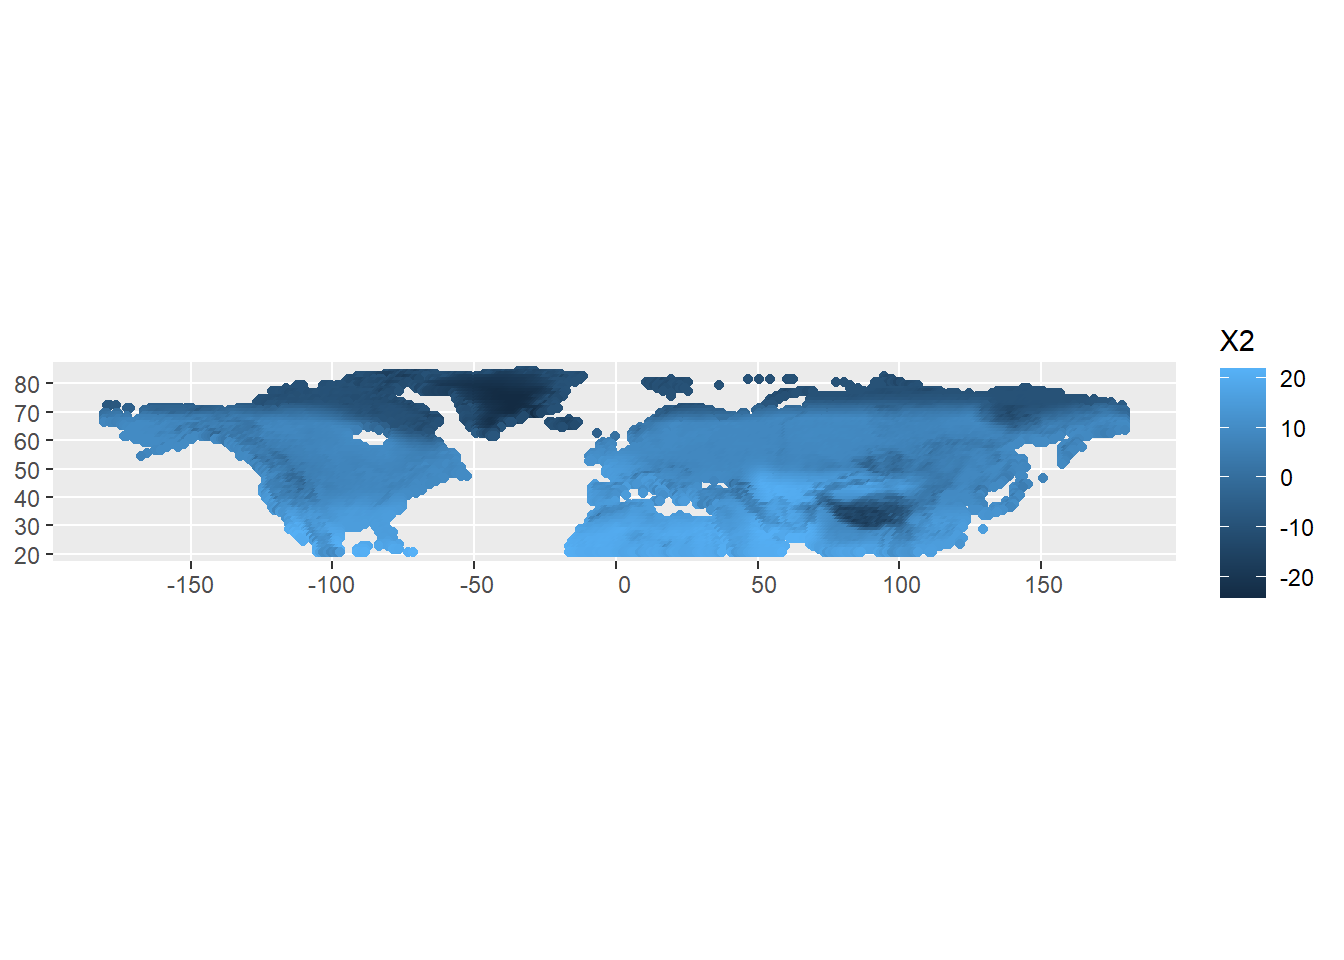

In [ ]:
east_corrected[[1]] %>% 
  ggplot() + 
  geom_sf(aes(col = X2))


standardized climate distribution for 21 Ma

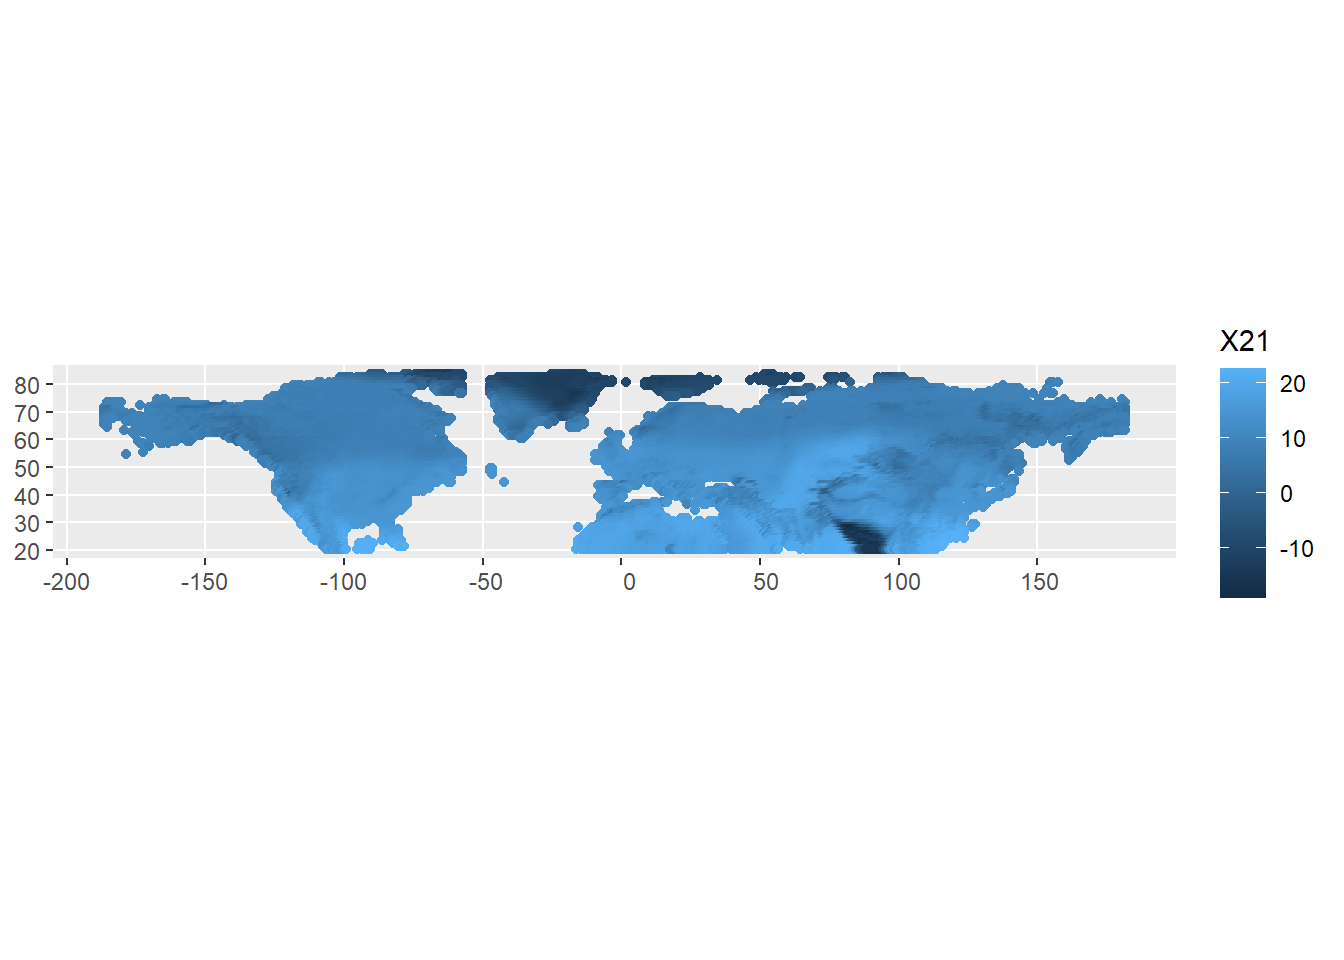

In [ ]:
east_corrected[[20]] %>% 
  ggplot() + 
  geom_sf(aes(col = X21))


Seem comparable now! With raster stacks, we can now aggregate and extract regional climatic data across time periods for the Neogene and save it as a raster list

In [ ]:
raster_corrected <- east_corrected %>% 
  imap(~{ rasterFromXYZ(data.frame(st_coordinates(.x), 
                                   'Temp' = .x %>% pull(.y)))})

raster_temp <- east %>% 
  dplyr::select(paste0('X', 2:23)) %>% 
  imap(~{
    
    e_corr <- .x %>% 
      cbind(
        east %>% 
          dplyr::select(c('x', 'y'))
      )%>% 
      setNames(c(.y, 'x', 'y')) %>% 
      distinct(x,y, .keep_all = T) %>% 
      filter(complete.cases(.))
    
    
    st_as_sf(e_corr, coords = c('x', 'y'))
    
  }) |> 
  imap(~{ rasterFromXYZ(data.frame(st_coordinates(.x), 
                                   'Temp' = .x %>% pull(.y)))})

saveRDS(raster_corrected, 'Data/temperature_grid/raster_corrected.rds')
saveRDS(raster_temp, 'Data/temperature_grid/raster_temp.rds')


In [ ]:
raster_corrected <- readRDS('Data/temperature_grid/raster_corrected.rds')


## Feature creation

aggregate into time bin periods

In [ ]:
## define a dictionary of time epoch 

time_bins <- list('Aquitanian' = c(23,22,21), 
                  'Burdigalian' = c(20,19,18,17,16), 
                  'Langhian' = c(15,14), 
                  'Serravallian' = c(13,12), 
                  'Tortonian' = c(8:11),
                  'Messinian' = c(6,7), 
                  'Zanclean' = c(5:4), 
                  'Piacenzian' = c(2,3))


In [ ]:
## extract the fossil matches from temperature for each region 

Temp_binned <- time_bins %>%  map(function(bin){
  
  paste0('X',bin) %>% map(~{
    pluck(raster_temp, .x) %>% 
      raster::crop(.,reg_gridded)
  }) %>% stack()
  
})

Temp_binned_mean <- Temp_binned |> map(~mean(.x, na.rm = T))


In [ ]:
## Temporally aggregate temperature records for each grid 
saveRDS(Temp_binned_mean, 'DATA/temperature_grid/Temp_binned_mean.rds')
saveRDS(Temp_binned, 'DATA/temperature_grid/Temp_binned.rds')


In [ ]:
Temp_binned <- readRDS('DATA/temperature_grid/Temp_binned.rds')
Temp_binned_mean <- readRDS('DATA/temperature_grid/Temp_binned_mean.rds')


Let’s now observe the change in atmospheric temperature across geological periods

In [ ]:
# Function to convert raster to data frame and assign the period name
raster_to_df <- function(raster, period) {
  raster_df <- as.data.frame(raster, xy = TRUE)
  raster_df$period <- period
  return(raster_df)
}


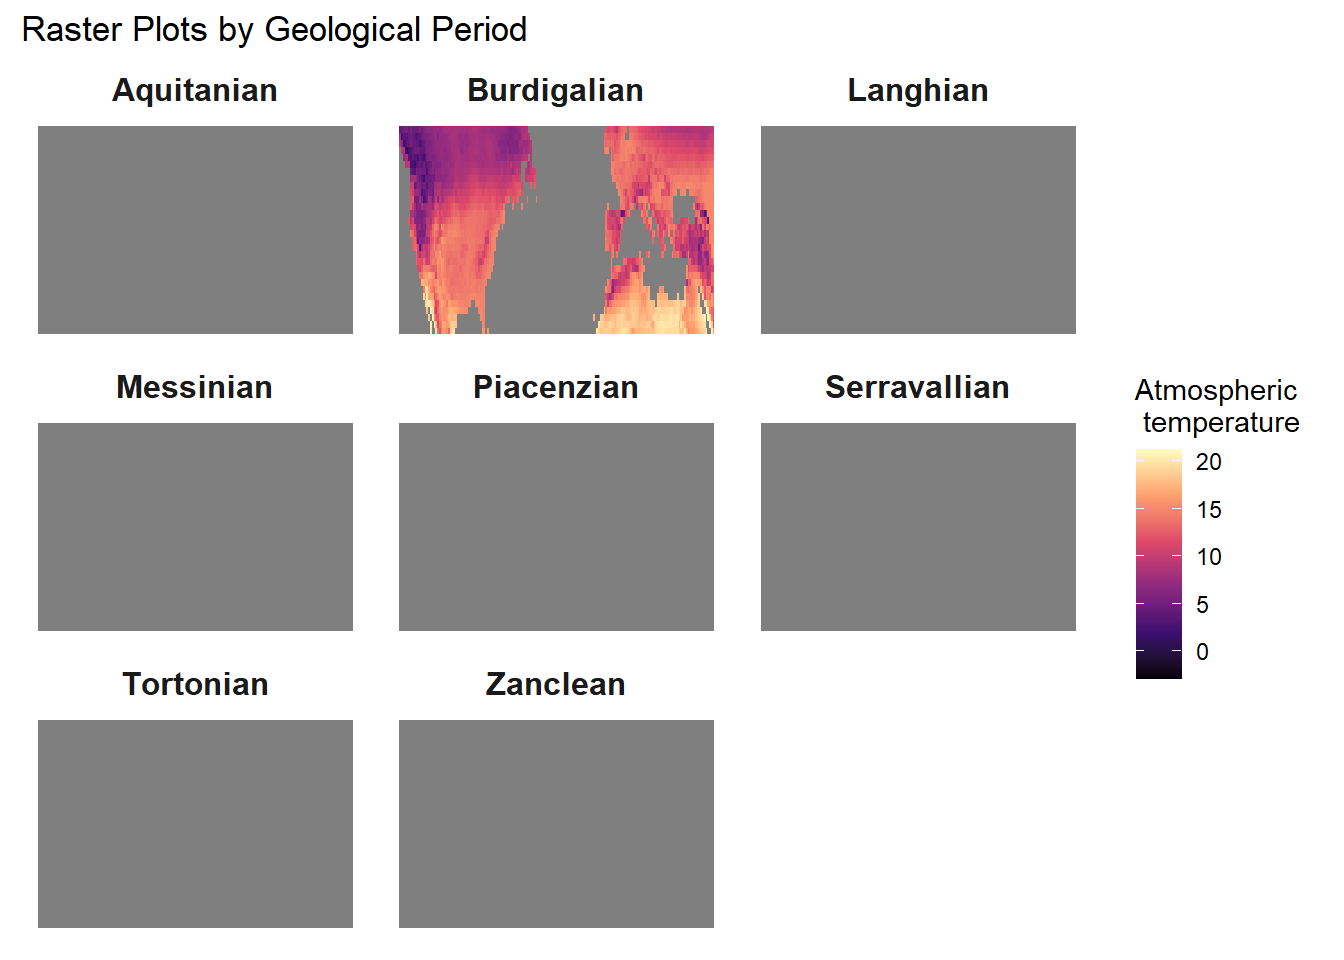

In [ ]:
# Combine all rasters into a single data frame with period information
raster_df_list <- lapply(names(Temp_binned_mean), function(period) raster_to_df(Temp_binned[[period]], period))
combined_df <- bind_rows(raster_df_list)

# Reshape the data for ggplot2
combined_df <- combined_df %>%
  reshape2::melt(id.vars = c("x", "y", "period"))


# Plot using ggplot2 with facet_wrap, ordered by geological period
ggplot(combined_df, aes(x = x, y = y, fill = value)) +
  geom_raster() +
  scale_fill_viridis_c(option = 'A') + # You can choose different color scales if you prefer
  facet_wrap(~ period, ncol = 3) + # Adjust ncol for the number of columns in facets
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  ) +
  labs(title = "Raster Plots by Geological Period", fill = "Atmospheric  \n temperature")
